In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from tempfile import TemporaryFile
import csv
import numpy as np
from skimage.transform import resize
from PIL import Image
import matplotlib.pyplot as plt
import cv2

In [0]:
X = np.load('/content/gdrive/My Drive/data_4_levels_balanced_32_32_3.npy') 
Y = np.load('/content/gdrive/My Drive/labels_4_levels_balanced.npy')

In [0]:
print(X.shape)
print(X)

(6254, 32, 32, 3)
[[[[191. 199. 184.]
   [193. 199. 185.]
   [196. 200. 186.]
   ...
   [209. 205. 196.]
   [211. 208. 199.]
   [210. 210. 200.]]

  [[192. 198. 184.]
   [193. 199. 185.]
   [196. 200. 186.]
   ...
   [206. 202. 193.]
   [205. 202. 193.]
   [203. 203. 193.]]

  [[194. 198. 184.]
   [195. 197. 184.]
   [196. 198. 185.]
   ...
   [208. 204. 195.]
   [204. 201. 192.]
   [203. 200. 191.]]

  ...

  [[157. 154. 145.]
   [158. 155. 146.]
   [149. 146. 137.]
   ...
   [172. 172. 162.]
   [164. 166. 155.]
   [168. 170. 159.]]

  [[165. 165. 157.]
   [167. 167. 159.]
   [161. 161. 153.]
   ...
   [172. 172. 164.]
   [164. 165. 157.]
   [167. 170. 161.]]

  [[162. 165. 158.]
   [142. 145. 138.]
   [137. 138. 132.]
   ...
   [172. 172. 164.]
   [164. 165. 157.]
   [165. 171. 161.]]]


 [[[205. 209. 195.]
   [205. 209. 195.]
   [206. 208. 195.]
   ...
   [209. 213. 199.]
   [205. 211. 197.]
   [203. 209. 195.]]

  [[205. 209. 195.]
   [205. 209. 195.]
   [207. 209. 196.]
   ...
   

In [0]:
print(Y.shape)
print(Y)

(6254, 4)
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 ...
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]


In [0]:
from sklearn.utils import shuffle
X, Y = shuffle(X, Y, random_state=0)

In [0]:
x_train = X[:5254]
y_train = Y[:5254]
print(x_train.shape)
print(y_train.shape)

(5254, 32, 32, 3)
(5254, 4)


In [0]:
x_val = X[5254:5754]
y_val = Y[5254:5754]
print(x_val.shape)
print(y_val.shape)

(500, 32, 32, 3)
(500, 4)


In [0]:
x_test = X[5754:]
y_test = Y[5754:]
print(x_test.shape)
print(y_test.shape)

(500, 32, 32, 3)
(500, 4)


(32, 32, 3)


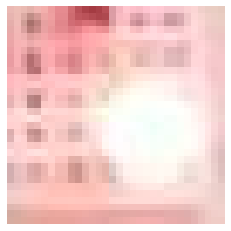

[0. 0. 0. 1.]


In [0]:
# picking a test sample before generating adversarial examples 
Image = x_test[ 0, :]
print( Image.shape )
r,g,b = cv2.split(Image)       # get b,g,r
Image = cv2.merge([r,g,b])

plt.imshow( Image.astype('uint8') )
plt.axis( 'off' )
plt.show( )
print(y_test[2])

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [0]:
import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.


In [0]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
import keras
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg = Model(vgg.input, output=output)
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
____________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(Tensor("in..., outputs=Tensor("fl...)`
  import sys


In [0]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from keras.regularizers import l2
model_Sigmoid = Sequential()
model_Sigmoid.add(vgg)
model_Sigmoid.add(Dense(512, activation='relu', input_dim=(32,32,3), kernel_regularizer=l2(0.001)))
model_Sigmoid.add(Dropout(0.2))
model_Sigmoid.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_Sigmoid.add(Dropout(0.2))
model_Sigmoid.add(Dense(4, activation='sigmoid'))
model_Sigmoid.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['accuracy'])
model_Sigmoid.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 512)               14714688  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 2052      
Total params: 15,242,052
Trainable params: 527,364
Non-trainable params: 14,714,688
____________________________________

In [0]:
# RMSprop ###(lr = 0.001 -> [59.39NOG, 58.2OG, 23.8N])###(lr = 0.0001 -> [72.2GG, 75.59GG, 73.4GG])###(lr = 0.00001 -> [70.2GG, 69.99GG, 73.00GG])###
# Adam ###(lr = 0.001 -> [49.59N, 23.8N, 23.8N])###(lr = 0.0001 -> [68.4GG, 72.2GG, 72.0NOG])###(lr = 0.00001 -> [27.59N, 61.0GG, 67.59GG])###
# SGD ###(lr = 0.001 -> [64.8GG, 68.4OG, 70.39OG])###(lr = 0.0001 -> [47.4OG, 56.19OG, 38.4N])###(lr = 0.00001 -> [41.2OG, 29.39N, 34.79OG])###
# N = No learning, GG = Great Learning, OG = Okay Learning, U = Unlearning

#RMSprop lr = 0.0001          ### 73.79% (RMSprop, lr = 0.0001, f1 = 0.741143) ###

model_Sigmoid.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Train on 5254 samples, validate on 500 samples
Epoch 1/10
5254/5254 [==============================] - 7s 1ms/step - loss: 1.8995 - accuracy: 0.5801 - val_loss: 1.5248 - val_accuracy: 0.6600
Epoch 2/10
5254/5254 [==============================] - 1s 170us/step - loss: 1.5223 - accuracy: 0.6894 - val_loss: 1.4235 - val_accuracy: 0.7120
Epoch 3/10
5254/5254 [==============================] - 1s 174us/step - loss: 1.3896 - accuracy: 0.7069 - val_loss: 1.3031 - val_accuracy: 0.6980
Epoch 4/10
5254/5254 [==============================] - 1s 169us/step - loss: 1.2961 - accuracy: 0.7242 - val_loss: 1.2357 - val_accuracy: 0.7420
Epoch 5/10
5254/5254 [==============================] - 1s 171us/step - loss: 1.2189 - accuracy: 0.7402 - val_loss: 1.1603 - val_accuracy: 0.7240
Epoch 6/10
5254/5254 [==============================] - 1s 167us/step - loss: 1.1469 - accuracy: 0.7402 - val_loss: 1.1421 - val_accuracy: 0.7420
Epoch 7/10
5254/5254 [==============================] - 1s 171us/step - loss: 1

In [0]:
model_Sigmoid.evaluate(x_test, y_test)

500/500 [==============================] - 0s 553us/step


[0.9773378620147705, 0.7360000014305115]

In [0]:
# predict probabilities for test set
yhat_probs_Sigmoid = model_Sigmoid.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes_Sigmoid = model_Sigmoid.predict_classes(x_test, verbose=0)
yhat_probs_Sigmoid = np.argmax(yhat_probs_Sigmoid, axis=1)
print(yhat_probs_Sigmoid.shape)
print(yhat_classes_Sigmoid.shape)

(500,)
(500,)


In [0]:
print(y_test.shape)
y_test_Sigmoid = np.argmax(y_test, axis=1)
print(y_test_Sigmoid.shape)

(500, 4)
(500,)


In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy_Sigmoid = accuracy_score(y_test_Sigmoid, yhat_classes_Sigmoid)
print('Accuracy Sigmoid: %f' % accuracy_Sigmoid)
# precision tp / (tp + fp)
precision_Sigmoid = precision_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('Precision Sigmoid: %f' % precision_Sigmoid)
# recall: tp / (tp + fn)
recall_Sigmoid = recall_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('Recall Sigmoid: %f' % recall_Sigmoid)
# f1: 2 tp / (2 tp + fp + fn)
f1_Sigmoid = f1_score(y_test_Sigmoid, yhat_classes_Sigmoid, average='macro')
print('F1 score Sigmoid: %f' % f1_Sigmoid)

Accuracy Sigmoid: 0.736000
Precision Sigmoid: 0.805224
Recall Sigmoid: 0.755307
F1 score Sigmoid: 0.734346


In [0]:
model_Softmax = Sequential()
model_Softmax.add(vgg)
model_Softmax.add(Dense(512, activation='relu', input_dim=(32,32,3), kernel_regularizer=l2(0.001)))
model_Softmax.add(Dropout(0.2))
model_Softmax.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_Softmax.add(Dropout(0.2))
model_Softmax.add(Dense(4, activation='softmax'))
model_Softmax.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
model_Softmax.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 512)               14714688  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 2052      
Total params: 15,242,052
Trainable params: 527,364
Non-trainable params: 14,714,688
____________________________________

In [0]:
# RMSprop ###(lr = 0.001 -> [89.8NOG, 94.19OG, 93.0GG])###(lr = 0.0001 -> [93.0GG, 93.4GG, 92.79GG])###(lr = 0.00001 -> [81.0GG, 82.8GG, 84.39GG])###
# Adam ###(lr = 0.001 -> [94.4OG, 93.59OG, 93.99NOG])###(lr = 0.0001 -> [92.59GG, 91.39GG, 91.39GG])###(lr = 0.00001 -> [83.2GG, 82.8GG, 83.39GG])###
# SGD ###(lr = 0.001 -> [89.6OG, 90.79GG, 88.99NOG])###(lr = 0.0001 -> [80.59GG, 82.99GG, 80.59GG])###(lr = 0.00001 -> [66.39GG, 68.59GG, 65.2GG])###
# N = No learning, GG = Great Learning, OG = Okay Learning, U = Unlearning

#Adam lr = 0.001        ### 95.99% (Adam, lr = 0.001, f1 = 0.958710) ###

model_Softmax.fit(x_train, y_train, batch_size=64, epochs=10, validation_data=(x_val, y_val))

Train on 5254 samples, validate on 500 samples
Epoch 1/10
5254/5254 [==============================] - 1s 223us/step - loss: 2.6739 - accuracy: 0.7699 - val_loss: 1.1654 - val_accuracy: 0.8720
Epoch 2/10
5254/5254 [==============================] - 1s 178us/step - loss: 1.1709 - accuracy: 0.8618 - val_loss: 1.0220 - val_accuracy: 0.8820
Epoch 3/10
5254/5254 [==============================] - 1s 176us/step - loss: 0.9988 - accuracy: 0.8826 - val_loss: 0.9098 - val_accuracy: 0.9160
Epoch 4/10
5254/5254 [==============================] - 1s 177us/step - loss: 0.8890 - accuracy: 0.9092 - val_loss: 0.9165 - val_accuracy: 0.8960
Epoch 5/10
5254/5254 [==============================] - 1s 176us/step - loss: 0.8156 - accuracy: 0.9237 - val_loss: 0.8215 - val_accuracy: 0.9220
Epoch 6/10
5254/5254 [==============================] - 1s 178us/step - loss: 0.7813 - accuracy: 0.9256 - val_loss: 0.7752 - val_accuracy: 0.9280
Epoch 7/10
5254/5254 [==============================] - 1s 177us/step - loss:

In [0]:
model_Softmax.evaluate(x_test, y_test)

500/500 [==============================] - 0s 225us/step


[0.6128862566947937, 0.9440000057220459]

In [0]:
# predict probabilities for test set
yhat_probs_Softmax = model_Softmax.predict(x_test, verbose=0)
# predict crisp classes for test set
yhat_classes_Softmax = model_Softmax.predict_classes(x_test, verbose=0)
yhat_probs_Softmax = np.argmax(yhat_probs_Softmax, axis=1)
print(yhat_probs_Softmax.shape)
print(yhat_classes_Softmax.shape)

(500,)
(500,)


In [0]:
print(y_test.shape)
y_test_Softmax = np.argmax(y_test, axis=1)
print(y_test_Softmax.shape)

(500, 4)
(500,)


In [0]:
# accuracy: (tp + tn) / (p + n)
accuracy_Softmax = accuracy_score(y_test_Softmax, yhat_classes_Softmax)
print('Accuracy Softmax: %f' % accuracy_Softmax)
# precision tp / (tp + fp)
precision_Softmax = precision_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('Precision Softmax: %f' % precision_Softmax)
# recall: tp / (tp + fn)
recall_Softmax = recall_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('Recall Softmax: %f' % recall_Softmax)
# f1: 2 tp / (2 tp + fp + fn)
f1_Softmax = f1_score(y_test_Softmax, yhat_classes_Softmax, average='macro')
print('F1 score Softmax: %f' % f1_Softmax)

Accuracy Softmax: 0.944000
Precision Softmax: 0.943009
Recall Softmax: 0.944181
F1 score Softmax: 0.943058
